In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
tejasreddy_iam_handwriting_top50_path = kagglehub.dataset_download('tejasreddy/iam-handwriting-top50')
andrewmvd_car_plate_detection_path = kagglehub.dataset_download('andrewmvd/car-plate-detection')
naderabdalghani_iam_handwritten_forms_dataset_path = kagglehub.dataset_download('naderabdalghani/iam-handwritten-forms-dataset')
francescopettini_license_plate_characters_detection_ocr_path = kagglehub.dataset_download('francescopettini/license-plate-characters-detection-ocr')
ahmadaneeq_tags_licenseplate_path = kagglehub.dataset_download('ahmadaneeq/tags-licenseplate')

print('Data source import complete.')


Data source import complete.


code adapted from

https://github.com/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_Seq2SeqTrainer.ipynb

https://huggingface.co/microsoft/trocr-base-printed

https://huggingface.co/docs/transformers/v4.28.1/en/model_doc/vision-text-dual-encoder

https://huggingface.co/docs/transformers/v4.28.1/en/model_doc/trocr#transformers.TrOCRForCausalLM


In [2]:
!pip install -U datasets huggingface_hub fsspec



  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [3]:
!pip install evaluate

In [4]:
from datasets import load_dataset
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator
import evaluate
import torch
import time



In [5]:
from datasets import load_dataset
ds = load_dataset("Teklia/IAM-line")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 6482
    })
    validation: Dataset({
        features: ['image', 'text'],
        num_rows: 976
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 2915
    })
})

In [7]:
# Cargar el procesador TrOCR
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

# Preprocesado
def preprocess(example):
    image = example["image"].convert("RGB")
    text = example["text"]

    pixel_values = processor(image, return_tensors="pt").pixel_values[0]
    labels = processor.tokenizer(
        text, padding="max_length", max_length=128, truncation=True
    ).input_ids

    labels = [l if l != processor.tokenizer.pad_token_id else -100 for l in labels]

    return {"pixel_values": pixel_values, "labels": labels}

# Aplicar
dataset = ds.map(preprocess, remove_columns=["image", "text"])
dataset.set_format(type="torch", columns=["pixel_values", "labels"])


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Map:   0%|          | 0/2915 [00:00<?, ? examples/s]

In [8]:
!pip install imgaug
#!pip install numpy==1.26.4


In [9]:
import torch
import numpy as np
from torchvision.transforms import ToPILImage
from PIL import Image
from imgaug import augmenters as iaa

# Augmentadores definidos
augmenters = iaa.Sequential([
    iaa.AdditiveGaussianNoise(scale=(10, 30)),
    iaa.GammaContrast((0.5, 1.5)),
    iaa.Sometimes(0.5, iaa.SaltAndPepper(0.05)),
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0.5, 2.0))),
    iaa.Sometimes(0.6, iaa.MotionBlur(k=5, angle=[-45, 45])),
    iaa.Sometimes(0.5, iaa.Multiply((0.7, 1.3))),
])

# Transforma una entrada del dataset
def degrade_image(image):
    # De PIL Image a numpy array
    img_np = np.array(image)

    # Aumentación
    img_aug_np = augmenters(image=img_np)

    # Vuelve a PIL Image
    img_aug = Image.fromarray(img_aug_np)

    return img_aug

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 6482
    })
    validation: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 976
    })
    test: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 2915
    })
})

In [11]:
from torchvision.transforms import ToPILImage
import torch

to_pil = ToPILImage()

def transform(example):
    # Asegúrate de que esté en formato tensor si no lo está
    tensor = torch.tensor(example["pixel_values"])
    if tensor.ndim == 3:
        img = to_pil(tensor)
    else:
        img = to_pil(tensor[0])  # si está en forma (1, C, H, W)

    # Aplica la degradación a la imagen PIL
    degraded_img = degrade_image(img)

    # Vuelve a tensor normalizado para mantener el formato del dataset
    # Convertir la imagen PIL degradada a numpy array
    degraded_img_np = np.array(degraded_img)
    # Asegurarse de que el array numpy tenga el formato (C, H, W) y normalizarlo
    degraded_img_tensor = torch.tensor(degraded_img_np).permute(2, 0, 1).float() / 255.0


    # Usa el procesador para obtener los pixel_values en el formato correcto
    # processor expects a PIL image or a list of PIL images
    pixel_values = processor(degraded_img, return_tensors="pt").pixel_values[0]
    example["pixel_values"] = pixel_values
    return example

dataset = dataset.with_transform(transform)


In [37]:
dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 6482
    })
    validation: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 976
    })
    test: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 2915
    })
})

In [12]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")


config.json:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
# import matplotlib.pyplot as plt
# # Display a single sample's data (image, label, etc.)
# sample = ds['train'][0]
# print("Image path:", sample['image'])
# print("Text label:", sample['text'])
# plt.imshow(sample['image'])
# print(len(ds['train']))


In [14]:
import os
import time
import numpy as np
import pandas as pd
import cv2
import json
from PIL import Image

output_dir = '/kaggle/working/output'
os.makedirs(output_dir, exist_ok=True)

In [15]:
from bs4 import BeautifulSoup

def get_string(file):

    with open(file, 'r') as f:
        data = f.read()

    # Passing the stored data inside the beautifulsoup parser
    bs_data = BeautifulSoup(data, 'xml')

    # Finding all instances of tag
    b_unique = bs_data.find_all('object')
    return ''.join([i.find('name').text for i in b_unique])

def yolo_to_abs(data_dict):#, scale=100.0):
    cord = {}

    original_width = data_dict['original_width']
    original_height = data_dict['original_height']

    pixel_x = int(data_dict['x']/100. * original_width)
    pixel_y = int(data_dict['y']/100. * original_height)
    pixel_width = int(data_dict['width']/100. * original_width)
    pixel_height = int(data_dict['height']/100. * original_height)
#     return[pixel_x, pixel_y, pixel_width, pixel_height]
    cord['x1'] = pixel_x -2#- pixel_width #/2)*original_width
    cord['y1'] = pixel_y -2#- pixel_height#/2)*original_height
    cord['x2'] = pixel_x + pixel_width +5 #/2)*original_width
    cord['y2'] = pixel_y + pixel_height + 5#/2)*original_height
    return cord

In [16]:
def preprocess(image, width: int, height: int, cval: int = 255, mode="letterbox", return_scale=False,):
    """Obtain a new image, fit to the specified size.
    Args:
        image: The input image
        width: The new width
        height: The new height
        cval: The constant value to use to fill the remaining areas of
            the image
        return_scale: Whether to return the scale used for the image
    Returns:
        The new image
    """
    fitted = None
    x_scale = width / image.shape[1]
    y_scale = height / image.shape[0]
    if x_scale == 1 and y_scale == 1:
        fitted = image
        scale = 1
    elif (x_scale <= y_scale and mode == "letterbox") or (
        x_scale >= y_scale and mode == "crop"
    ):
        scale = width / image.shape[1]
        resize_width = width
        resize_height = (width / image.shape[1]) * image.shape[0]
    else:
        scale = height / image.shape[0]
        resize_height = height
        resize_width = scale * image.shape[1]
    if fitted is None:
        resize_width, resize_height = map(int, [resize_width, resize_height])
        if mode == "letterbox":
            fitted = np.zeros((height, width, 3), dtype="uint8") + cval
            image = cv2.resize(image, dsize=(resize_width, resize_height))
            fitted[: image.shape[0], : image.shape[1]] = image[:height, :width]
        elif mode == "crop":
            image = cv2.resize(image, dsize=(resize_width, resize_height))
            fitted = image[:height, :width]
        else:
            raise NotImplementedError(f"Unsupported mode: {mode}")
    if not return_scale:
        return fitted
    return fitted, scale

# Process license-plate-characters-detection-ocr

In [17]:
# image_dir = '/kaggle/input/license-plate-characters-detection-ocr/LP-characters/images'
# annotations_dir = '/kaggle/input/license-plate-characters-detection-ocr/LP-characters/annotations'

# lic_record = []

# for im_name in sorted(os.listdir(image_dir)):
#     image_path = os.path.join(image_dir, im_name)

#     annot_path = os.path.join(annotations_dir, im_name.split('.')[0]+'.xml')
#     label_string = get_string(annot_path)

#     lic_record.append(dict(text=str(label_string), file_name=image_path))


In [18]:
# image_dir = '/kaggle/input/license-plate-characters-detection-ocr/LP-characters/images'
# annotations_dir = '/kaggle/input/license-plate-characters-detection-ocr/LP-characters/annotations'

lic_record = []

for i in range(len(ds['train'])):
    image_path = ds['train'][i]['image']

#     annot_path = os.path.join(annotations_dir, im_name.split('.')[0]+'.xml')
    label_string = ds['train'][i]['text']

    lic_record.append(dict(text=str(label_string), file_name=image_path))


In [19]:
# print(lic_record[len(lic_record)-1])
# print(label_string)
# plt.imshow(image_path)

In [20]:
df1 = pd.DataFrame(lic_record)
df1.to_csv('/kaggle/working/lic_labels1.csv')

df1.head()


,text,file_name
0,put down a resolution on the subject,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,and he is to be backed by Mr. Will,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,nominating any more Labour life Peers,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,M Ps tomorrow. Mr. Michael Foot has,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,"Griffiths, M P for Manchester Exchange .",<PIL.JpegImagePlugin.JpegImageFile image mode=...


In [21]:
df1

,text,file_name
0,put down a resolution on the subject,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,and he is to be backed by Mr. Will,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,nominating any more Labour life Peers,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,M Ps tomorrow. Mr. Michael Foot has,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,"Griffiths, M P for Manchester Exchange .",<PIL.JpegImagePlugin.JpegImageFile image mode=...
...,...,...
6477,beside # Catherine . She had the stories open,<PIL.JpegImagePlugin.JpegImageFile image mode=...
6478,In the train going back to London I sat,<PIL.JpegImagePlugin.JpegImageFile image mode=...
6479,I wish I went to that school . Did you notice,<PIL.JpegImagePlugin.JpegImageFile image mode=...
6480,that girl who said hullo to him in the garden ?,<PIL.JpegImagePlugin.JpegImageFile image mode=...


# Process car-plate-detection dataset

In [22]:
# license_no_data = pd.read_csv('/kaggle/input/tags-licenseplate/ocr-licence-plate.csv')
# # license_no_data = license_no_data.sample(frac = 1)
# license_no_data['ocr'] = license_no_data['ocr'].apply(lambda x: x.split('-')[-1])

# license_no_data

In [23]:
# license_no_data = pd.read_csv('/kaggle/input/tags-licenseplate/ocr-licence-plate.csv')
# # license_no_data = license_no_data.sample(frac = 1)
# license_no_data['ocr'] = license_no_data['ocr'].apply(lambda x: x.split('-')[-1])

# license_no_data

In [24]:
# lic_record = []
# path_car_img = "/kaggle/input/car-plate-detection/images"
# os.makedirs("/kaggle/working/images/", exist_ok=True)
# for row, val in  license_no_data.iterrows():                         # need improvement
#     img_dir = os.path.join(path_car_img, val['ocr'])
#     image = cv2.imread(img_dir, cv2.IMREAD_ANYCOLOR)
#     try:
#         label_s = json.loads(val['transcription'])
#     except ValueError:
#         label_s = str(val['transcription'])
#     for num, bbox in enumerate(json.loads(val['bbox'])):
#         path_to_save = f"/kaggle/working/images/{val['ocr'].split('.')[0]}_{num}.jpg"

#         cart_cord = yolo_to_abs(bbox)
#         crop_img = image[cart_cord['y1']:cart_cord['y2'],
#                          cart_cord['x1']:cart_cord['x2']]
#         crop_img = preprocess(crop_img, width=200, height=100)

# #         process_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2GRAY) #.astype("float32")[..., np.newaxis]
#         im_croped = Image.fromarray(crop_img)

#         im_croped.save(path_to_save)
#         if isinstance(label_s, list):
#             lic_record.append( dict(text=str(label_s[num]), file_name=path_to_save))
#         else:
#             lic_record.append(dict(text=str(label_s), file_name = path_to_save))

In [25]:
# df2 = pd.DataFrame(lic_record)
# df2.to_csv('/kaggle/working/lic_labels.csv')
# df2.sort_values('file_name', inplace=True)
# df2

## Mixing datasets

In [26]:
from sklearn.model_selection import train_test_split

# test_df = pd.concat([df1[-21:],df2[-21:]])
test_df = df1[-21:]
# df = pd.concat([df1[:-21], df2[:-21]])
df = df1[:-21]
# train_df, valid_df = train_test_split(df[:-21], test_size=0.2)
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=0)

# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [27]:
print(df1.shape)
print(train_df.shape, valid_df.shape,test_df.shape)

(6482, 2)
(5168, 2) (1293, 2) (21, 2)


# Download/Load Model

In [28]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# If you want to start from the pretrained model, load the checkpoint with `VisionEncoderDecoderModel`
# processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')

# TrOCR is a decoder model and should be used within a VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [29]:
import torch
from torch.utils.data import Dataset

class LPDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = file_name.convert("RGB")  # ✅ ya es una imagen

        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(
            text, padding="max_length", max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

    def __iter__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)

In [30]:
root_dir = ''

class LPDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, df, processor):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        # image = Image.open(self.root_dir + file_name).convert("RGB") # Original line
        image = file_name.convert("RGB") # Use the image object directly
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, padding="max_length", max_length=self.processor.tokenizer.model_max_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

train_dataset = LPDataset(root_dir, df=train_df, processor=processor)

test_dataset = LPDataset(root_dir, df=test_df, processor=processor)

eval_dataset = LPDataset(root_dir, df=valid_df, processor=processor)

In [31]:
# processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
# pixel_values = processor(images=image, return_tensors="pt").pixel_values

# generated_ids = model.generate(pixel_values)
# generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [32]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [33]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 38.7 MB/s eta 0:00:00


In [34]:
import evaluate
import jiwer

# Cargar la métrica CER desde Hugging Face evaluate
wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")



def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # Decodificar predicciones
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)

    # Reemplazar -100 por el token de padding antes de decodificar las etiquetas reales
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    # Calcular CER
    wer_score = wer_metric.compute(predictions=pred_str, references=label_str)
    cer_score = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer_score, "wer": wer_score}


In [35]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator

training_args = Seq2SeqTrainingArguments(
    output_dir="./output",
    overwrite_output_dir=True,
    learning_rate=5e-5,                      # 🔧 tasa de aprendizaje inicial
    num_train_epochs=5,                         # 1 época para pruebas rápidas
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    eval_strategy="epoch",                # ✅ evaluar al final de cada época
    save_strategy="epoch",                      # ✅ guardar al final de cada época
    logging_strategy="epoch",                   # ✅ log solo al final
    report_to="none"
)


trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

/usr/local/lib/python3.11/dist-packages/transformers/models/trocr/processing_trocr.py:152: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
<ipython-input-35-3002481327>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [39]:
train_time = time.time() ## in UTC time
trainer.train()
train_time = time.time() - train_time

print('Train time (sec)', train_time)

Epoch,Training Loss,Validation Loss,Cer,Wer
1,3.001300,2.600621,0.535942,0.722604
2,1.546900,1.892184,0.455636,0.587342
3,0.869800,1.524238,0.428531,0.568535
4,0.457600,1.340755,0.434423,0.565371
5,0.207100,1.246615,0.412077,0.551537


/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1730: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Train time (sec) 3838.320362329483


In [40]:
save_time = time.time()
model.save_pretrained("/kaggle/working/vit-ocr")
save_time = time.time() - save_time
print('save_time time (sec)', save_time)

save_time time (sec) 4.096877098083496


In [41]:
score_model = VisionEncoderDecoderModel.from_pretrained('/kaggle/working/vit-ocr')
print(score_model)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (i

# Inference

In [42]:
# file_image = '/kaggle/input/license-plate-characters-detection-ocr/LP-characters/images/0055.png'
file_image = ds['train'][3]['image']
# image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
# image = Image.open(file_image).convert("RGB")
image = file_image.convert("RGB")
score_time = time.time()

pixel_values = processor(image, return_tensors="pt").pixel_values
# text = "industry, ' Mr. Brown commented icily. ' Let us have a"
# if torch.cuda.is_available():
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pixel_values = pixel_values.to(device)
# # inference
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

score_time = time.time() - score_time
print('score_time (sec)', score_time)

M tomorrow Mr Michael Foot Foot Foot
score_time (sec) 0.5461573600769043


In [ ]:
image

In [ ]:
pixel_values.shape

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

def compare_string(true_label, pred_label):

    true_label = true_label.replace(" ", "").replace('-','').replace('0','O')
    pred_label =  pred_label.replace(" ", "").replace('-','').replace('0','O')

    if pred_label == true_label:
        return True

    return False

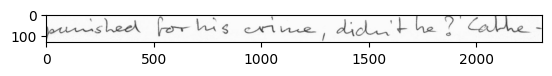

true_label:  punished for his crime , didn't he ? ' cathe-
pred_label:  pun for time ,'t , he ? the the the


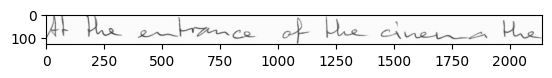

true_label:  at the entrance of the cinema the
pred_label:  at the of cinema the the the


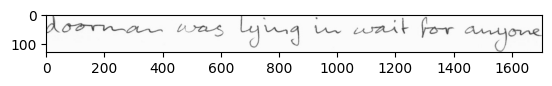

true_label:  doorman was lying in wait for anyone
pred_label:  door was was in for anyone anyone anyone


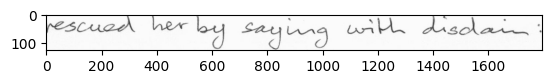

true_label:  rescued her by saying with disdain :
pred_label:  res her saying with :


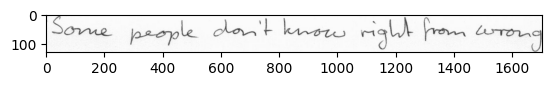

true_label:  ' some people don't know right from wrong
pred_label:  ' people don don don know from wrong


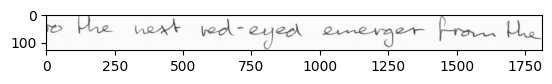

true_label:  to the next red-eyed emerger from the
pred_label:  to the red- emerge from from the


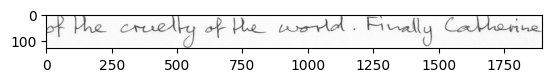

true_label:  of the cruelty of the world . finally catherine
pred_label:  of the of world the . catherineatherine


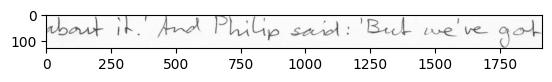

true_label:  about it . ' and philip said : ' but we 've got
pred_label:  about it ' philip : : : said ' he got got


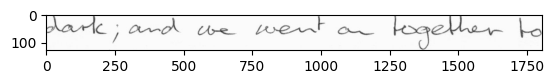

true_label:  dark ; and we went on together to
pred_label:  d ; ; we on went together


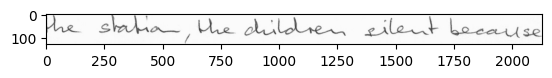

true_label:  the station , the children silent because
pred_label:  the station the silver because because


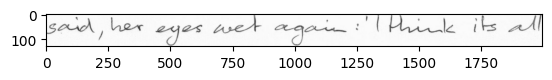

true_label:  said , her eyes wet again : ' i think its all
pred_label:  said , eyes wet wet : again iink all


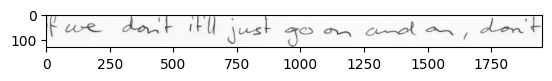

true_label:  if we don't it 'll just go on and on , don't
pred_label:  if we it just just on an ,'t


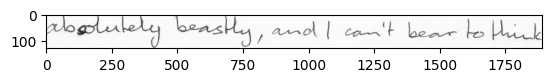

true_label:  absolutely beastly , and i can't bear to think
pred_label:  abol beauty , , , i't bear think


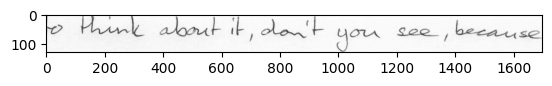

true_label:  to think about it , don't you see , because
pred_label:  to think it don it don't see because because


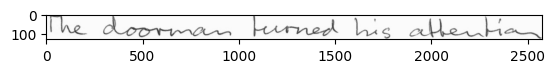

true_label:  the doorman turned his attention
pred_label:  the human his attention


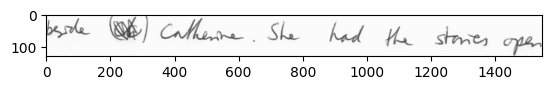

true_label:  beside # catherine . she had the stories open
pred_label:  best ( ( ) ) . . . ) . had stories


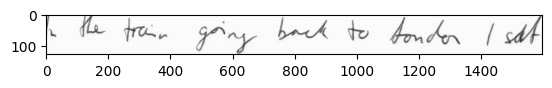

true_label:  in the train going back to london i sat
pred_label:  & the giving back london s i


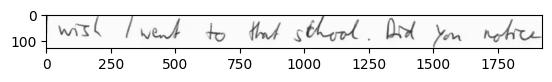

true_label:  i wish i went to that school . did you notice
pred_label:  i i i i to school . you notice


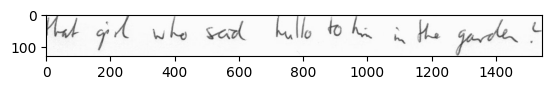

true_label:  that girl who said hullo to him in the garden ?
pred_label:  that glad who said to in to in the !


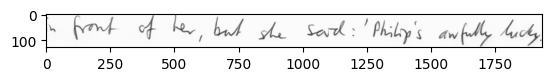

true_label:  in front of her , but she said : ' philip 's awfully lucky .
pred_label:  in of of , she but said : philip anything hardly . .


In [44]:
correct_char = 0
total_char = 0
correct = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for _, val  in test_df.iterrows():

    image = val['file_name'].convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    pred_label = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    true_label = val['text']

#     pr = prediction[i]
# #     tr = y_true[i]
#     total_char += len(true_label)
    correct_char += SequenceMatcher(None, true_label, pred_label).ratio()

# #     for j in range(min(len(true_label), len(pred_label))):
# #         if true_label[j] == pred_label[j]:
# #             correct_char += 1

    if compare_string(true_label, pred_label) :
        correct += 1
    else:
        plt.imshow(np.asarray(image))
        plt.show()
        print('true_label: ',true_label.lower())
        print('pred_label: ',pred_label.lower())

  0%|          | 0/21 [00:00<?, ?it/s]

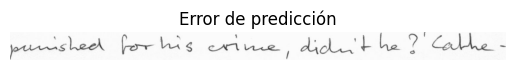

  5%|▍         | 1/21 [00:00<00:06,  3.23it/s]

TRUE: punished for his crime , didn't he ? ' Cathe-
PRED: pun for time ,'t , he ? the the the


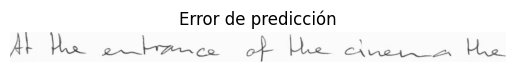

 10%|▉         | 2/21 [00:00<00:05,  3.67it/s]

TRUE: At the entrance of the cinema the
PRED: At the of cinema the the the


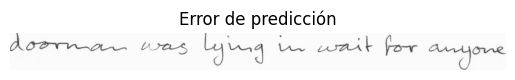

 14%|█▍        | 3/21 [00:00<00:04,  3.87it/s]

TRUE: doorman was lying in wait for anyone
PRED: door was was in for anyone anyone anyone


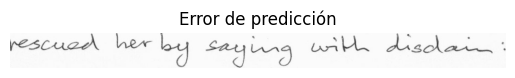

 19%|█▉        | 4/21 [00:00<00:04,  4.24it/s]

TRUE: rescued her by saying with disdain :
PRED: res her saying with :


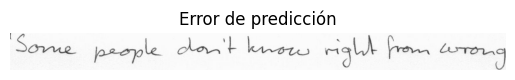

 24%|██▍       | 5/21 [00:01<00:03,  4.06it/s]

TRUE: ' Some people don't know right from wrong
PRED: ' people don don don know from wrong


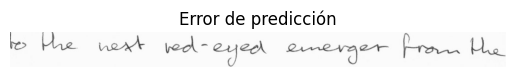

 29%|██▊       | 6/21 [00:01<00:03,  4.06it/s]

TRUE: to the next red-eyed emerger from the
PRED: to the red- emerge from from the


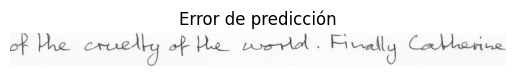

 33%|███▎      | 7/21 [00:01<00:04,  3.24it/s]

TRUE: of the cruelty of the world . Finally Catherine
PRED: of the of world the . Catherineatherine


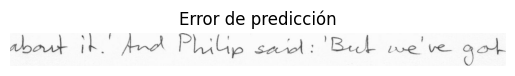

 43%|████▎     | 9/21 [00:02<00:03,  3.99it/s]

TRUE: about it . ' And Philip said : ' But we 've got
PRED: about it ' Philip : : : said ' he got got


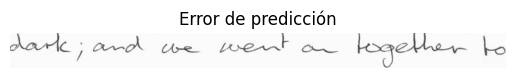

 48%|████▊     | 10/21 [00:02<00:02,  4.05it/s]

TRUE: dark ; and we went on together to
PRED: d ; ; we on went together


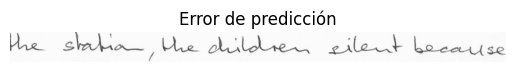

 52%|█████▏    | 11/21 [00:02<00:02,  4.27it/s]

TRUE: the station , the children silent because
PRED: the station the silver because because


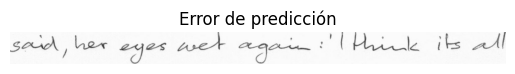

 57%|█████▋    | 12/21 [00:03<00:02,  3.99it/s]

TRUE: said , her eyes wet again : ' I think its all
PRED: said , eyes wet wet : again Iink all


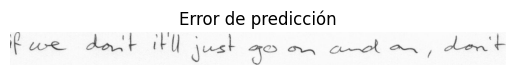

 62%|██████▏   | 13/21 [00:03<00:02,  3.91it/s]

TRUE: if we don't it 'll just go on and on , don't
PRED: If we it just just on an ,'t


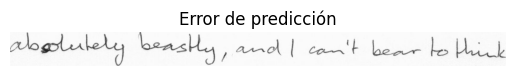

 67%|██████▋   | 14/21 [00:03<00:02,  3.19it/s]

TRUE: absolutely beastly , and I can't bear to think
PRED: abol beauty , , , I't bear think


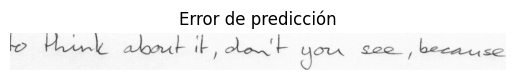

 71%|███████▏  | 15/21 [00:04<00:01,  3.17it/s]

TRUE: to think about it , don't you see , because
PRED: to think it don it don't see because because


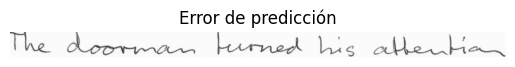

 76%|███████▌  | 16/21 [00:04<00:01,  3.60it/s]

TRUE: The doorman turned his attention
PRED: The human his attention


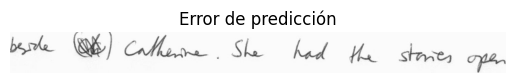

 81%|████████  | 17/21 [00:04<00:01,  2.89it/s]

TRUE: beside # Catherine . She had the stories open
PRED: best ( ( ) ) . . . ) . had stories


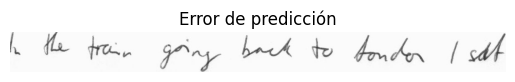

 86%|████████▌ | 18/21 [00:05<00:00,  3.23it/s]

TRUE: In the train going back to London I sat
PRED: & the giving back London s I


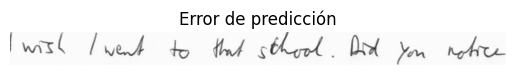

 90%|█████████ | 19/21 [00:05<00:00,  3.31it/s]

TRUE: I wish I went to that school . Did you notice
PRED: I I I I to school . you notice


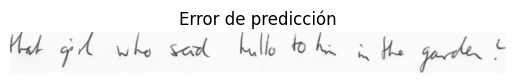

 95%|█████████▌| 20/21 [00:05<00:00,  2.85it/s]

TRUE: that girl who said hullo to him in the garden ?
PRED: that glad who said to in to in the !


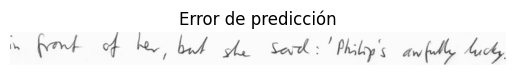

100%|██████████| 21/21 [00:06<00:00,  3.41it/s]

TRUE: in front of her , but she said : ' Philip 's awfully lucky .
PRED: in of of , she but said : Philip anything hardly . .

✅ CER: 0.4385
✅ WER: 0.5737


In [45]:
import torch
from difflib import SequenceMatcher
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import evaluate  # métrica CER/WER oficial de Hugging Face

# Inicializar métricas
wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")

# Listas para almacenar predicciones y etiquetas reales
predictions = []
references = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Evaluación
for _, val in tqdm(test_df.iterrows(), total=len(test_df)):

    image = val['file_name'].convert("RGB")
    text_true = val['text']

    # Preprocesamiento e inferencia
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)
    text_pred = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Guardar para métricas
    references.append(text_true)
    predictions.append(text_pred)

    # Mostrar si hay error (opcional)
    if text_true.strip().lower() != text_pred.strip().lower():
        plt.imshow(np.asarray(image))
        plt.title("Error de predicción")
        plt.axis("off")
        plt.show()
        print("TRUE:", text_true)
        print("PRED:", text_pred)

# Calcular CER y WER
cer = cer_metric.compute(predictions=predictions, references=references)
wer = wer_metric.compute(predictions=predictions, references=references)

print(f"\n✅ CER: {cer:.4f}")
print(f"✅ WER: {wer:.4f}")


In [46]:
# correct_char = 0
# total_char = 0
# correct = 0

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# for _, val  in test_df.iterrows():

#     image = Image.open(val['file_name']).convert("RGB")
#     pixel_values = processor(image, return_tensors="pt").pixel_values
#     pixel_values = pixel_values.to(device)
#     generated_ids = model.generate(pixel_values)
#     pred_label = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

#     true_label = val['text']

# #     pr = prediction[i]
# # #     tr = y_true[i]
# #     total_char += len(true_label)
#     correct_char += SequenceMatcher(None, true_label, pred_label).ratio()

# # #     for j in range(min(len(true_label), len(pred_label))):
# # #         if true_label[j] == pred_label[j]:
# # #             correct_char += 1

#     if compare_string(true_label, pred_label) :
#         correct += 1
#     else:
#         plt.imshow(np.asarray(image))
#         plt.show()
#         print('true_label',true_label)
#         print('pred_label',pred_label)

# Result on test dataset

In [47]:
print(f'correct {correct}, total {len(test_df)}')
print('performance on test  data')
print('Correct characters predicted : %.2f%%' %(correct_char*100/test_df.shape[0]))
print('Correct lines predicted      : %.2f%%' %(correct*100/test_df.shape[0]))

correct 1, total 21
performance on test  data
Correct characters predicted : 69.87%
Correct lines predicted      : 4.76%


In [48]:
# correct_char = 0
# total_char = 0
# correct = 0

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# for _, val  in lic_df.iterrows():

#     image = Image.open(val['file']).convert("RGB")
#     pixel_values = processor(image, return_tensors="pt").pixel_values
#     pixel_values = pixel_values.to(device)
#     generated_ids = model.generate(pixel_values)
#     pred_label = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

#     true_label = val['label']

# #     pr = prediction[i]
# # #     tr = y_true[i]
# #     total_char += len(true_label)
#     correct_char += SequenceMatcher(None, true_label, pred_label).ratio()

# # #     for j in range(min(len(true_label), len(pred_label))):
# # #         if true_label[j] == pred_label[j]:
# # #             correct_char += 1

#     if compare_string(true_label, pred_label) :
#         correct += 1
#     else:
#         plt.imshow(np.asarray(image))
#         plt.show()
#         print('true_label',true_label)
#         print('pred_label',pred_label)

In [49]:
# print('performance on original data')
# print('Correct characters predicted : %.2f%%' %(correct_char*100/lic_df.shape[0]))
# print('Correct words predicted      : %.2f%%' %(correct*100/lic_df.shape[0]))